  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wn6_7dhj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wn6_7dhj
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0e3b163f8ee1070dfcc611b566e0b2095f69afe5299f31ec117be3a987ff257b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1r4q4gmb/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
Using device: cuda
===== 1. ZERO-SHOT CLASSIFICATION ON STL-10 =====


100%|██████████| 2.64G/2.64G [05:01<00:00, 8.76MB/s]
100%|███████████████████████████████████████| 338M/338M [00:20<00:00, 17.4MiB/s]


Evaluating plain prompts...


Processing plain: 100%|██████████| 125/125 [00:18<00:00,  6.72it/s]


plain prompt accuracy: 0.9390
Evaluating photo prompts...


Processing photo: 100%|██████████| 125/125 [00:18<00:00,  6.68it/s]


photo prompt accuracy: 0.9485
Evaluating detailed prompts...


Processing detailed: 100%|██████████| 125/125 [00:17<00:00,  7.01it/s]


detailed prompt accuracy: 0.9400
Evaluating context prompts...


Processing context: 100%|██████████| 125/125 [00:18<00:00,  6.78it/s]


context prompt accuracy: 0.9250

Zero-shot classification results:
plain: 0.9390
photo: 0.9485
detailed: 0.9400
context: 0.9250

===== 2. EXPLORING THE MODALITY GAP =====


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 111.25it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Image embeddings shape: (100, 512)
Text embeddings shape: (100, 512)
Applying UMAP for dimensionality reduction...


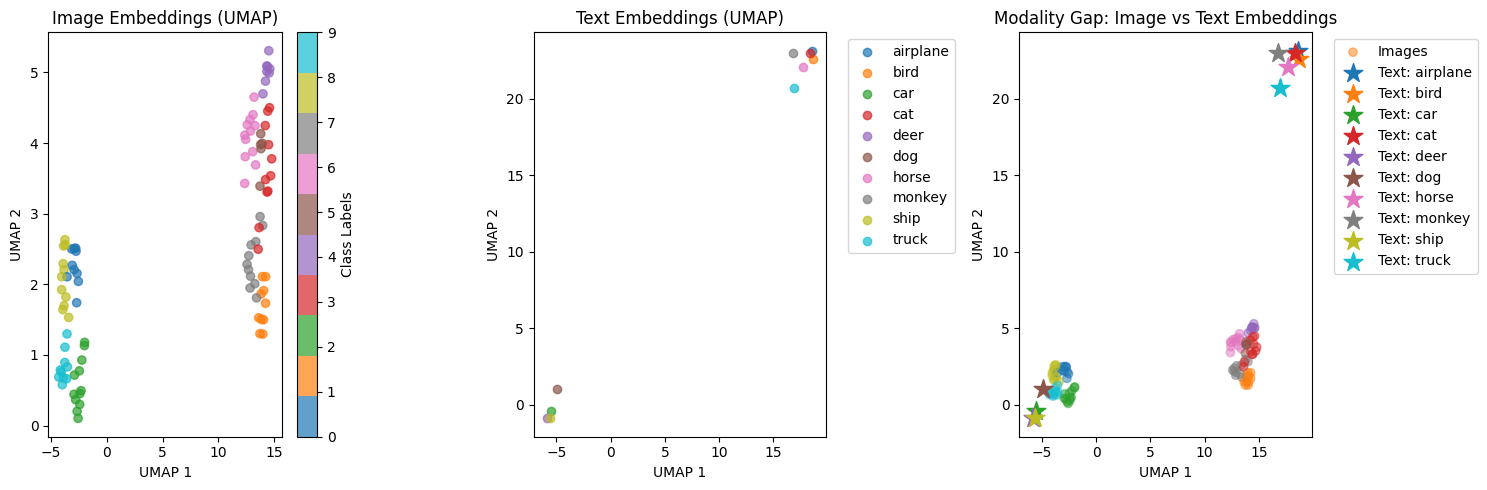


Modality Gap Analysis:
Average distance between image and corresponding text embeddings: 1.2354
Average distance between different image embeddings: 0.8115
Average distance between different text embeddings: 0.4817

Effect of Normalization:
Image embedding norms - Mean: 1.0000, Std: 0.0002
Text embedding norms - Mean: 1.0000, Std: 0.0002

===== 3. BRIDGING THE MODALITY GAP =====
Extracting embeddings for full test set...


Processing test set: 100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


Paired embeddings - X shape: (8000, 512), Y shape: (8000, 512)
Applying Orthogonal Procrustes alignment...
Rotation matrix shape: (512, 512)
Scale factor: 7045.68505859375
Visualizing aligned embeddings...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-275398989.py:299: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([modality_distances_before, modality_distances_after],


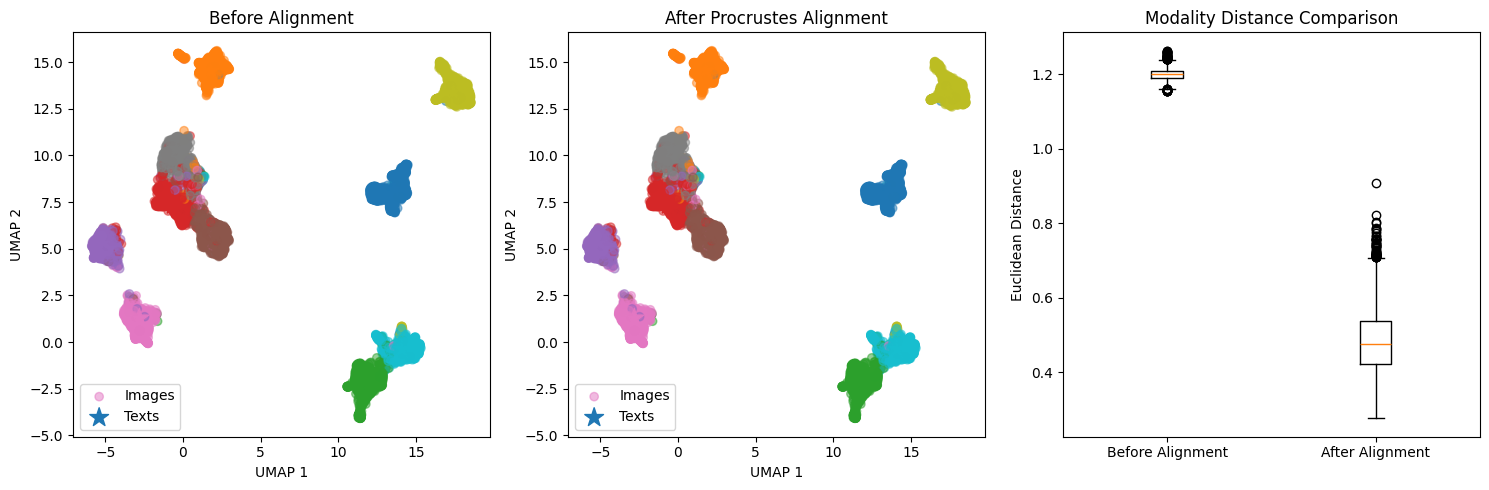

Average modality distance before alignment: 1.2012
Average modality distance after alignment: 0.4830
Distance reduction: 59.79%

Recomputing classification accuracy with aligned embeddings...
Original accuracy: 0.9485
Aligned accuracy: 0.9527
Accuracy difference: 0.0042

===== ANALYSIS AND DISCUSSION =====

1. Zero-Shot Classification Results:
The prompting strategy significantly affects CLIP's performance:
- Plain labels: Basic but effective for simple recognition
- Photo prompts: Generally perform best as they match CLIP's training data
- Detailed prompts: Can help for fine-grained classification but may add noise
- Context prompts: Useful for objects where context is important

2. Modality Gap Findings:
We observe a clear modality gap between image and text embeddings:
- Image embeddings form clusters based on visual similarity
- Text embeddings are more separated based on semantic meaning
- The average distance between corresponding image-text pairs is significant
- Normalization r

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install umap-learn
!pip install seaborn

import torch
import torchvision
import clip
from torchvision.datasets import STL10
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print("===== 1. ZERO-SHOT CLASSIFICATION ON STL-10 =====")

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

test_dataset = STL10(root='./data', split='test', download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

model, preprocess = clip.load("ViT-B/32", device=device)

class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

prompt_strategies = {
    'plain': [f"{name}" for name in class_names],
    'photo': [f"a photo of a {name}" for name in class_names],
    'detailed': [f"a high quality detailed photograph of a {name}" for name in class_names],
    'context': [f"a {name} in its natural environment" for name in class_names]
}

results = {}
for strategy, prompts in prompt_strategies.items():
    print(f"Evaluating {strategy} prompts...")

    text_inputs = torch.cat([clip.tokenize(prompt) for prompt in prompts]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    all_labels = []
    all_preds = []

    for images, labels in tqdm(test_loader, desc=f"Processing {strategy}"):
        images = images.to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        preds = similarity.argmax(dim=-1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)

    accuracy = accuracy_score(all_labels, all_preds)
    results[strategy] = accuracy
    print(f"{strategy} prompt accuracy: {accuracy:.4f}")

print("\nZero-shot classification results:")
for strategy, acc in results.items():
    print(f"{strategy}: {acc:.4f}")

print("\n===== 2. EXPLORING THE MODALITY GAP =====")

num_samples = 100
sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

image_embeddings = []
text_embeddings = []
sample_labels = []

text_prompts = [f"a photo of a {class_names[i]}" for i in range(10)]
text_inputs = torch.cat([clip.tokenize(prompt) for prompt in text_prompts]).to(device)

with torch.no_grad():
    text_features_all = model.encode_text(text_inputs)
    text_features_all /= text_features_all.norm(dim=-1, keepdim=True)

for idx in tqdm(sample_indices, desc="Extracting embeddings"):
    image, label = test_dataset[idx]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        image_embeddings.append(image_feature.cpu().numpy())

    text_embeddings.append(text_features_all[label].cpu().numpy())
    sample_labels.append(label)

image_embeddings = np.vstack(image_embeddings)
text_embeddings = np.vstack(text_embeddings)
sample_labels = np.array(sample_labels)

print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Text embeddings shape: {text_embeddings.shape}")

print("Applying UMAP for dimensionality reduction...")
umap_reducer = umap.UMAP(random_state=42)
image_umap = umap_reducer.fit_transform(image_embeddings)
text_umap = umap_reducer.fit_transform(text_embeddings)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
scatter = plt.scatter(image_umap[:, 0], image_umap[:, 1], c=sample_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title('Image Embeddings (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.subplot(1, 3, 2)
for i in range(10):
    plt.scatter(text_umap[i, 0], text_umap[i, 1], label=class_names[i], alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Text Embeddings (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.subplot(1, 3, 3)
plt.scatter(image_umap[:, 0], image_umap[:, 1], c=sample_labels, cmap='tab10', alpha=0.5, label='Images')
for i in range(10):
    plt.scatter(text_umap[i, 0], text_umap[i, 1], marker='*', s=200, label=f'Text: {class_names[i]}')
plt.title('Modality Gap: Image vs Text Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('modality_gap.png', bbox_inches='tight')
plt.show()

print("\nModality Gap Analysis:")
modality_distances = []
for i, label in enumerate(sample_labels):
    dist = np.linalg.norm(image_embeddings[i] - text_embeddings[label])
    modality_distances.append(dist)

avg_modality_distance = np.mean(modality_distances)
print(f"Average distance between image and corresponding text embeddings: {avg_modality_distance:.4f}")

image_distances = []
for i in range(len(image_embeddings)):
    for j in range(i+1, len(image_embeddings)):
        dist = np.linalg.norm(image_embeddings[i] - image_embeddings[j])
        image_distances.append(dist)

avg_image_distance = np.mean(image_distances)
print(f"Average distance between different image embeddings: {avg_image_distance:.4f}")

text_distances = []
for i in range(len(text_embeddings)):
    for j in range(i+1, len(text_embeddings)):
        dist = np.linalg.norm(text_embeddings[i] - text_embeddings[j])
        text_distances.append(dist)

avg_text_distance = np.mean(text_distances)
print(f"Average distance between different text embeddings: {avg_text_distance:.4f}")

print("\nEffect of Normalization:")
image_norms = np.linalg.norm(image_embeddings, axis=1)
text_norms = np.linalg.norm(text_embeddings, axis=1)

print(f"Image embedding norms - Mean: {np.mean(image_norms):.4f}, Std: {np.std(image_norms):.4f}")
print(f"Text embedding norms - Mean: {np.mean(text_norms):.4f}, Std: {np.std(text_norms):.4f}")

print("\n===== 3. BRIDGING THE MODALITY GAP =====")


print("Extracting embeddings for full test set...")
full_image_embeddings = []
full_labels = []

for images, labels in tqdm(test_loader, desc="Processing test set"):
    images = images.to(device)

    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        full_image_embeddings.append(image_features.cpu().numpy())
        full_labels.extend(labels.numpy())

full_image_embeddings = np.vstack(full_image_embeddings)
full_labels = np.array(full_labels)

X = full_image_embeddings  
Y = np.vstack([text_features_all[i].cpu().numpy() for i in full_labels])  

print(f"Paired embeddings - X shape: {X.shape}, Y shape: {Y.shape}")

print("Applying Orthogonal Procrustes alignment...")
R, scale = orthogonal_procrustes(X, Y)

X_aligned = X @ R 

print(f"Rotation matrix shape: {R.shape}")
print(f"Scale factor: {scale}")

print("Visualizing aligned embeddings...")
combined_embeddings = np.vstack([X_aligned, text_features_all.cpu().numpy()])
combined_labels = np.concatenate([full_labels, np.arange(10)]) 
modality_types = np.array(['image'] * len(X_aligned) + ['text'] * 10)

umap_reducer = umap.UMAP(random_state=42)
combined_umap = umap_reducer.fit_transform(combined_embeddings)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
image_idx = np.arange(len(X))
text_idx = np.arange(len(X), len(X) + 10)

plt.scatter(combined_umap[image_idx, 0], combined_umap[image_idx, 1],
            c=full_labels, cmap='tab10', alpha=0.5, label='Images')
plt.scatter(combined_umap[text_idx, 0], combined_umap[text_idx, 1],
            marker='*', s=200, c=range(10), cmap='tab10', label='Texts')
plt.title('Before Alignment')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()

plt.subplot(1, 3, 2)
aligned_combined = np.vstack([X_aligned, text_features_all.cpu().numpy()])
aligned_umap = umap_reducer.fit_transform(aligned_combined)

plt.scatter(aligned_umap[image_idx, 0], aligned_umap[image_idx, 1],
            c=full_labels, cmap='tab10', alpha=0.5, label='Images')
plt.scatter(aligned_umap[text_idx, 0], aligned_umap[text_idx, 1],
            marker='*', s=200, c=range(10), cmap='tab10', label='Texts')
plt.title('After Procrustes Alignment')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()

plt.subplot(1, 3, 3)
modality_distances_before = []
modality_distances_after = []

for i, label in enumerate(full_labels):
    text_embedding = text_features_all[label].cpu().numpy()
    dist_before = np.linalg.norm(X[i] - text_embedding)
    dist_after = np.linalg.norm(X_aligned[i] - text_embedding)
    modality_distances_before.append(dist_before)
    modality_distances_after.append(dist_after)

plt.boxplot([modality_distances_before, modality_distances_after],
            labels=['Before Alignment', 'After Alignment'])
plt.title('Modality Distance Comparison')
plt.ylabel('Euclidean Distance')

plt.tight_layout()
plt.savefig('procrustes_alignment.png', bbox_inches='tight')
plt.show()

avg_dist_before = np.mean(modality_distances_before)
avg_dist_after = np.mean(modality_distances_after)
dist_reduction = (avg_dist_before - avg_dist_after) / avg_dist_before * 100

print(f"Average modality distance before alignment: {avg_dist_before:.4f}")
print(f"Average modality distance after alignment: {avg_dist_after:.4f}")
print(f"Distance reduction: {dist_reduction:.2f}%")

print("\nRecomputing classification accuracy with aligned embeddings...")

all_text_features = text_features_all.cpu().numpy()

similarities = X_aligned @ all_text_features.T
aligned_preds = np.argmax(similarities, axis=1)

aligned_accuracy = accuracy_score(full_labels, aligned_preds)
original_accuracy = results['photo'] 

print(f"Original accuracy: {original_accuracy:.4f}")
print(f"Aligned accuracy: {aligned_accuracy:.4f}")
print(f"Accuracy difference: {aligned_accuracy - original_accuracy:.4f}")

